In [15]:
import os
import numpy as np
import shap
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.utils import resample

# GBM
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# MLP
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt

In [12]:
dfs = {
    "train": pd.read_csv("data/train.csv"),
    "sample": pd.read_csv("data/sample_submission.csv")
}

dfs['train'].head(10000000)

,id,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,0,58,1,4,152,239,0,0,158,1,3.6,2,2,7,Presence
1,1,52,1,1,125,325,0,2,171,0,0.0,1,0,3,Absence
2,2,56,0,2,160,188,0,2,151,0,0.0,1,0,3,Absence
3,3,44,0,3,134,229,0,2,150,0,1.0,2,0,3,Absence
4,4,58,1,4,140,234,0,2,125,1,3.8,2,3,3,Presence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629995,629995,56,0,1,110,226,0,0,132,0,0.0,1,0,7,Absence
629996,629996,54,1,4,128,249,1,2,150,0,0.0,2,0,3,Absence
629997,629997,67,1,4,130,275,0,0,149,0,0.0,1,2,7,Presence
629998,629998,52,1,4,140,199,0,2,157,0,0.0,1,0,6,Presence


In [8]:
# Figure out what the submission should be
dfs['sample'].head(10000000)

,id,Heart Disease
0,630000,0
1,630001,0
2,630002,0
3,630003,0
4,630004,0
...,...,...
269995,899995,0
269996,899996,0
269997,899997,0
269998,899998,0


# Reading the submission file
> Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

So for every ID, generate a probability. The more accurate the higher the score.

Now the goal before I go into determining which type of prediction strategy, I'm going to delve into any correlations in the dataset. This is going to be super critical because I know nothing about heart disease.

Before starting the challenge, I delved into other first place solutions in other competetions. They all used graphs. I think a heatmap is probably best for this to start along with the output distribution

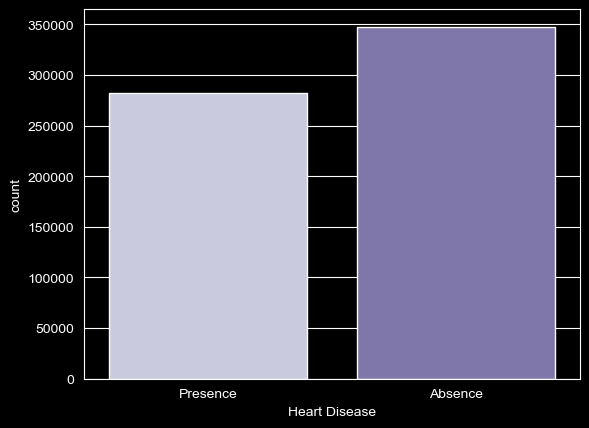

In [16]:
# This chart will show me how balanced the outputs are
df=dfs['train']
g = sns.countplot(
    data=df,
    x="Heart Disease",
    hue="Heart Disease",   # redundant, but required
    palette="Purples",
    legend=False           # so you don’t get a duplicate legend
)


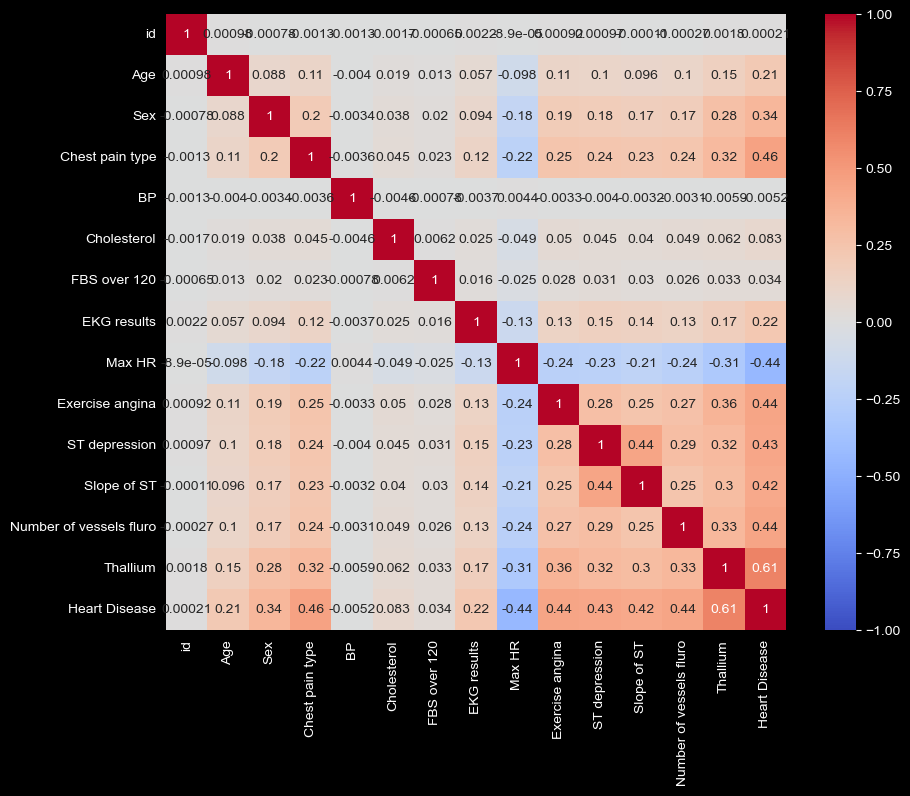

In [18]:
# Let's make a numeric df
# (for correlation matrix)
# The non-numeric is just the Heart Disease column
# 0 = no disease, 1 = has disease
mapping = {"Absence": 0, "Presence": 1}

numeric_df = df.copy()
numeric_df["Heart Disease"] = df["Heart Disease"].map(mapping)

corr_matrix = numeric_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8)) # Optional: Increases size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# Direct Insights
- Age 21%
- Sex 34%
- Chest pain type 46%
- EKG results 22%
- Max HR -44%
- Exercise angina 44%
- ST depression 43%
- Slope of ST 42%
- Number of vessels fluro 44%
- Thallium 61%

Let's delve deeper into the top ones.

I'll throw in FBS over 120 and Cholestrol for the layout.

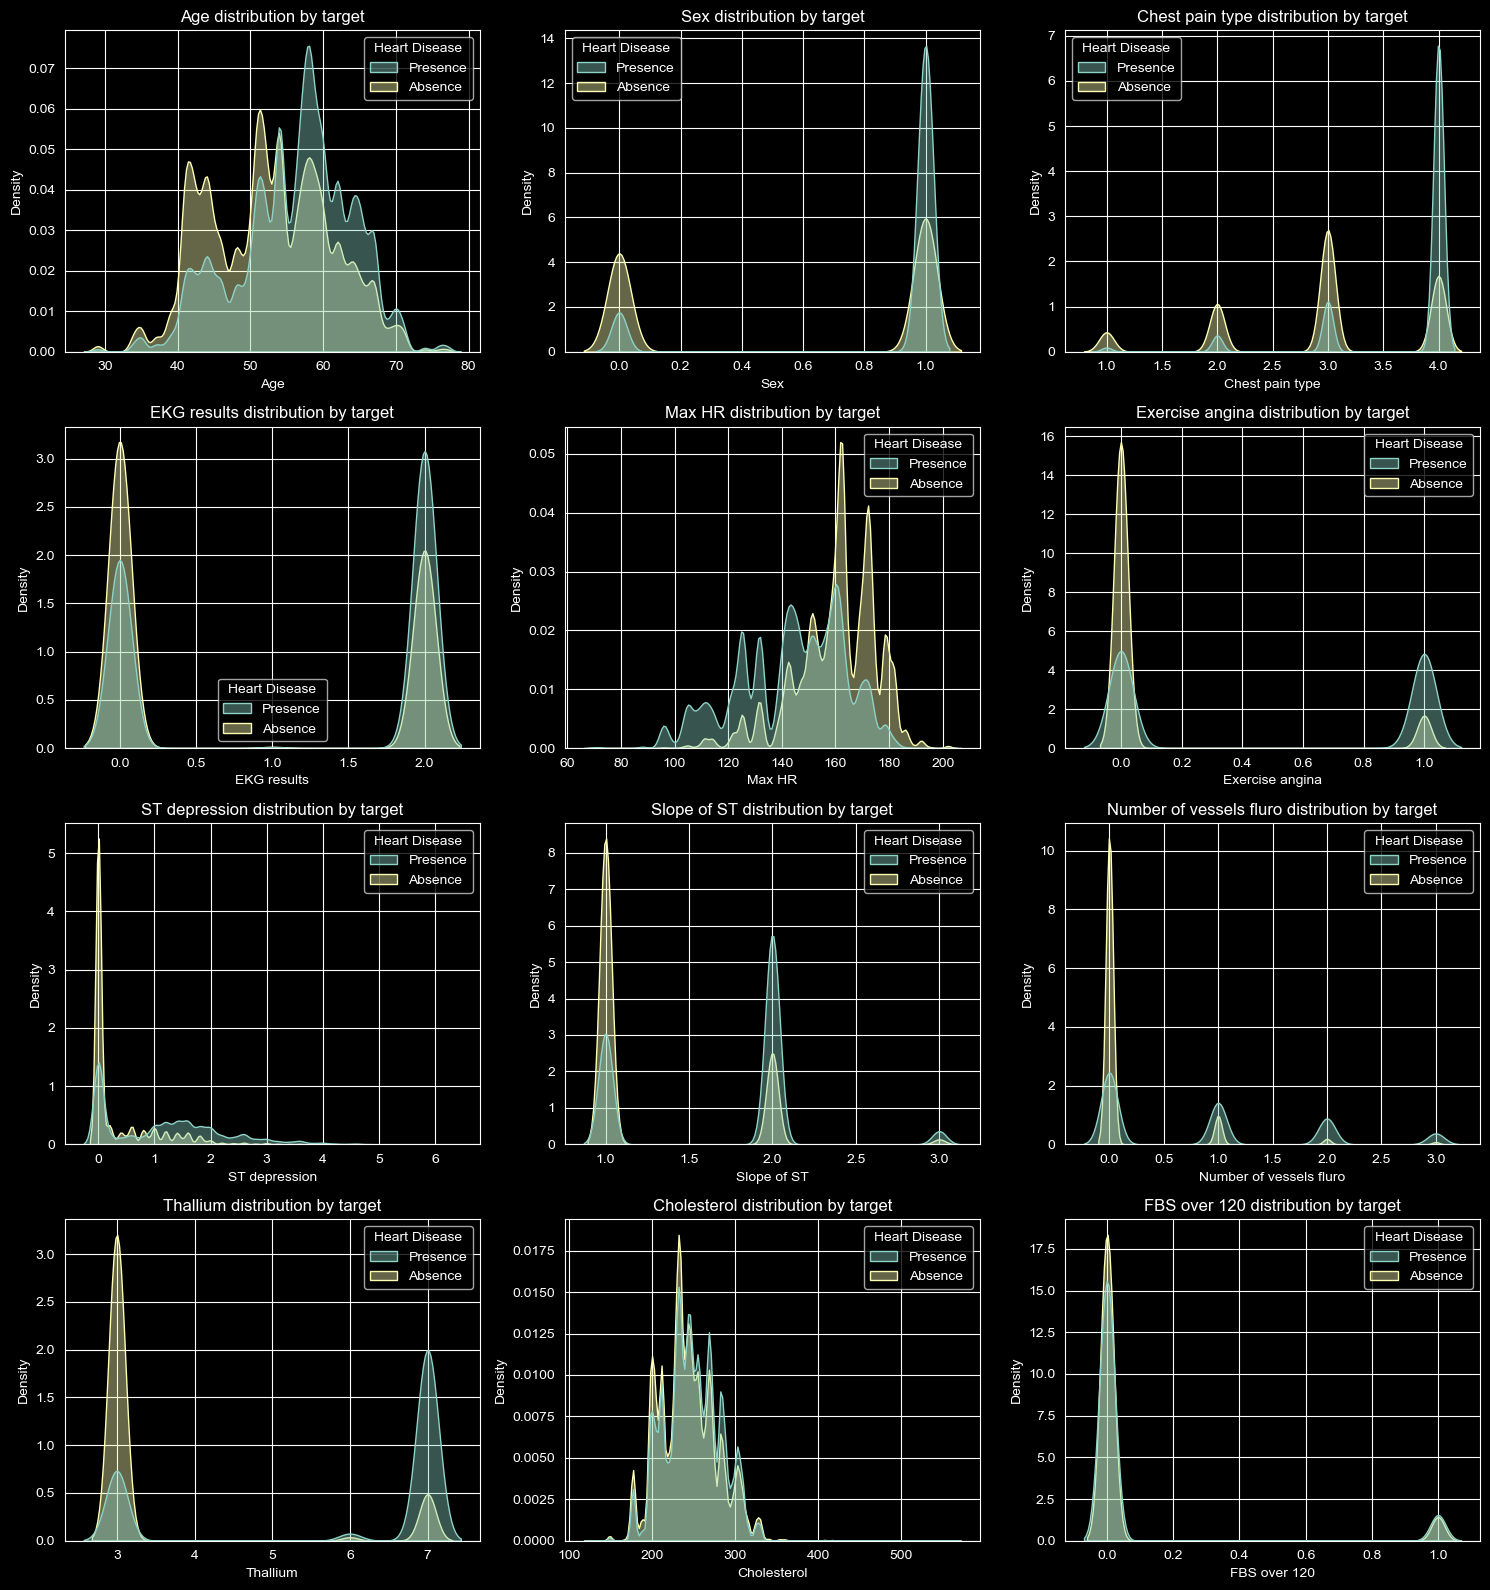

In [26]:
notable_features = [
    'Age', 'Sex', 'Chest pain type',
    'EKG results', 'Max HR', 'Exercise angina',
    'ST depression', 'Slope of ST',
    'Number of vessels fluro', 'Thallium',
    'Cholesterol', 'FBS over 120' # Bonus
]

n_cols = 3
n_plots = len(notable_features)
n_rows = int(np.ceil(n_plots / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(notable_features):
    ax = axes[i]
    sns.kdeplot(
        data=df,
        x=col,
        hue='Heart Disease',
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=ax
    )
    ax.set_title(f'{col} distribution by target')

# Turn off any unused axes (if n_plots not multiple of 3)
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

# Top Insights
1. Highly likely to be present if chest pain is 4
2. Highly likely to be absent if thallium is 3
3. Fluro 0.0 corresponds to highly unlikely
4. ST depression of 0 means highly unlikely
5. Cholestrial means nothing
6. Much more likely in the 1.0 gender

I think I understand the problem enough. Let's build some baseline models.

In [19]:
train_df = dfs['train'].copy()
test = pd.read_csv("data/test.csv")

train_df["Heart Disease"] = train_df["Heart Disease"].map(mapping)

X = train_df.drop(columns=['Heart Disease', 'id'])
y = train_df['Heart Disease']

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Let's make a baseline via logistic regression.

In [20]:
log_reg = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=5000, n_jobs=-1)
)

# 2. CV ROC–AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(log_reg, X, y, cv=cv, scoring="roc_auc")
print(scores.mean(), scores.std())

# 3. Fit on full train
log_reg.fit(X, y)

# 4. Predict on test with the SAME feature set (no id)
test_probs = log_reg.predict_proba(test.drop(columns=["id"]))[:, 1]

# 5. Build submission: id,Heart Disease
submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": test_probs
})

os.makedirs("submissions/logistic-regression", exist_ok=True)
submission.to_csv("submissions/logistic-regression/submission.csv", index=False)

0.9504900722631842 0.000337495201360605


Alright. So top 2048. It's oviously a baseline and really, just a 2% improvement is all I need.

I want to go for a top spot. Let's move onto gradient boosting since it's relatively easy and quick to do.

I have two options for this type of problem: MLP or GBM

In [15]:
# 2) XGBoost
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42,
)

# 3) LightGBM
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    metric="auc",
    n_jobs=-1,
    random_state=42,
)

# 4) CatBoost (silent training, simple config)
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=4,
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=False,
    random_seed=42,
)

models = {
    "log_reg": log_reg_pipeline,
    "xgb": xgb_model,
    "lgbm": lgbm_model,
    "cat": cat_model,
}

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "log_reg": log_reg_pipeline,
    "xgb": xgb_model,
    "lgbm": lgbm_model,
    "cat": cat_model,
}

results = []
for name, m in models.items():
    scores = cross_val_score(m, X, y, cv=cv, scoring="roc_auc")
    mean_score = scores.mean()
    std_score = scores.std()
    results.append({"model": name, "mean_roc_auc": mean_score, "std_roc_auc": std_score})


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 504000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448339 -> initscore=-0.207383
[LightGBM] [Info] Start training from score -0.207383
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018334 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

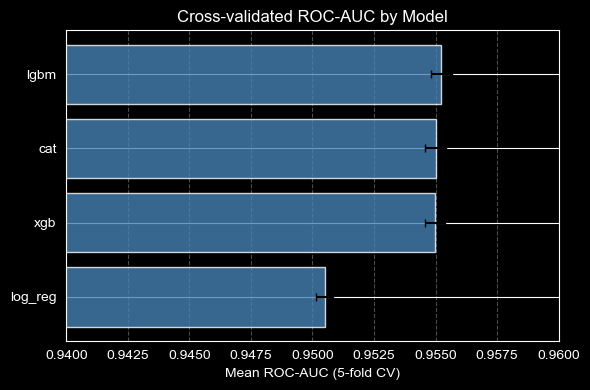

In [18]:
results_df = pd.DataFrame(results).sort_values("mean_roc_auc", ascending=True)

plt.figure(figsize=(6, 4))
plt.barh(
    results_df["model"],
    results_df["mean_roc_auc"],
    xerr=results_df["std_roc_auc"],
    alpha=0.8,
    color="steelblue",
    ecolor="black",
    capsize=3,
)
plt.xlabel("Mean ROC-AUC (5-fold CV)")
plt.title("Cross-validated ROC-AUC by Model")
plt.xlim(0.94, 0.96)  # zoom into the interesting range
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Save the top GBM (untuned) model
lgbm_model.fit(X, y)

# 2. Predict probabilities for positive class on test
test_features = test.drop(columns=["id"])
test_probs = lgbm_model.predict_proba(test_features)[:, 1]

# 3. Build submission DataFrame
submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": test_probs
})

# 4. Save to desired path
os.makedirs("submissions/untuned_gmb", exist_ok=True)
submission.to_csv("submissions/untuned_gmb/submission.csv", index=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 282454, number of negative: 347546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448340 -> initscore=-0.207381
[LightGBM] [Info] Start training from score -0.207381


So now I'm only top 1200. I want to get in the top 100 at least. Let's tune the LGBM model.

In [24]:
lgbm_base = LGBMClassifier(
    objective="binary",
    metric="auc",
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
)

param_dist = {
    "n_estimators": [400, 600, 800, 1000],
    "learning_rate": [0.03, 0.05, 0.07],
    "num_leaves": [15, 31, 63],
    "max_depth": [-1, 4, 6, 8],
    "min_child_samples": [20, 50, 100],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=lgbm_base,
    param_distributions=param_dist,
    n_iter=25,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

search.fit(X, y)
print("Best ROC-AUC:", search.best_score_)
print("Best params:", search.best_params_)

best_lgbm = search.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225964, number of negative: 278036
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 225963, number of negative: 278037
[LightGBM] [Warning]

Alright and let's now save this and see where we land in the competetion and how competetive it is.

In [25]:
# 1. Refit best_lgbm on full training data (optional but clean)
best_lgbm.fit(X, y)

# 2. Predict probabilities on test (drop id)
test_features = test.drop(columns=["id"])
test_probs = best_lgbm.predict_proba(test_features)[:, 1]

# 3. Build submission DataFrame
submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": test_probs
})

# 4. Save to tuned_gmb path
os.makedirs("submissions/tuned_gmb", exist_ok=True)
submission.to_csv("submissions/tuned_gmb/submission.csv", index=False)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 282454, number of negative: 347546
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417
[LightGBM] [Info] Number of data points in the train set: 630000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.448340 -> initscore=-0.207381
[LightGBM] [Info] Start training from score -0.207381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

> Your Best Entry!
> Your most recent submission scored 0.95348, which is an improvement over your previous score of 0.95329. Great job!

Let's see if we can go any higher. I still need to get slightly higher for a top 100 spot. Even the slightest 0.5 improvement would put me up near the top. Don't really need the MLP. GMB is capturing the complexity of the problem. Also just through the correlation matrix and previous graphs, this problem doesn't seem too complex and the extra naunce isn't worth it. We'll still make a CatBoost model and MLP to validate my reasoning here.

In [37]:
# Base CatBoost model
cat_base = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    verbose=False,
    random_seed=42,
)

# Trimmed, focused search space
cat_param_dist = {
    "depth": [4, 5],
    "learning_rate": [0.03, 0.05],
    "l2_leaf_reg": [2, 4, 6, 8],
    "random_strength": [0.5, 1.0, 2.0],
    "iterations": [400, 600],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cat_search = RandomizedSearchCV(
    estimator=cat_base,
    param_distributions=cat_param_dist,
    n_iter=12,           # lighter but still meaningful search
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# Hyperparameter search
cat_search.fit(X, y)
print("Best CatBoost ROC-AUC:", cat_search.best_score_)
print("Best CatBoost params:", cat_search.best_params_)

best_cat = cat_search.best_estimator_

# Refit on full train and create submission
best_cat.fit(X, y)
cat_test_probs = best_cat.predict_proba(test.drop(columns=["id"]))[:, 1]

cat_submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": cat_test_probs
})
os.makedirs("submissions/tuned_catboost", exist_ok=True)
cat_submission.to_csv("submissions/tuned_catboost/submission.csv", index=False)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [30]:
mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),  # simple 2-layer MLP
        activation="relu",
        solver="adam",
        alpha=1e-4,
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=300, # 50 Wasn't enough
        random_state=42
    )
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_scores = cross_val_score(mlp_model, X, y, cv=cv, scoring="roc_auc")
print("MLP ROC-AUC:", mlp_scores.mean(), mlp_scores.std())

MLP ROC-AUC: 0.9514902409744075 0.0005355803886068276


Let's save it and send it in. Let's also compare it to the other models.

In [31]:
mlp_model.fit(X, y)
mlp_test_probs = mlp_model.predict_proba(test.drop(columns=["id"]))[:, 1]

mlp_submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": mlp_test_probs
})
os.makedirs("submissions/mlp_baseline", exist_ok=True)
mlp_submission.to_csv("submissions/mlp_baseline/submission.csv", index=False)


I forgot to add early stopping 😑.
Let's try with early stopping and some tweaks because it's really done horribly in the competetion underperforming untuned GMB.

In [34]:
mlp_model = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        alpha=1e-3,              # stronger L2
        batch_size=256,
        learning_rate_init=1e-3,
        max_iter=100,
        early_stopping=True, # 😑
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
    )
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_scores = cross_val_score(mlp_model, X, y, cv=cv, scoring="roc_auc")
print("MLP ROC-AUC:", mlp_scores.mean(), mlp_scores.std())


MLP ROC-AUC: 0.9530130877253764 0.0003898805119646138


In [35]:
mlp_model.fit(X, y)
mlp_test_probs = mlp_model.predict_proba(test.drop(columns=["id"]))[:, 1]

mlp_submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": mlp_test_probs
})
os.makedirs("submissions/mlp_final", exist_ok=True)
mlp_submission.to_csv("submissions/mlp_final/submission.csv", index=False)

Alright so yeah I was right. LGMB is going to be the best path to optimize now. Let's try to find some connections between the data through some statistical models.

In [ ]:
best_lgbm = LGBMClassifier(
    objective="binary",
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    # best params from search
    num_leaves=31,
    n_estimators=800,
    min_child_samples=50,
    max_depth=4,
    learning_rate=0.05,
)

# refit on full training data
best_lgbm.fit(X, y)

X_sample = resample(X, n_samples=10000, random_state=42, replace=False)

explainer = shap.TreeExplainer(best_lgbm)
shap_inter = explainer.shap_interaction_values(X_sample)

mean_inter = np.abs(shap_inter).mean(axis=0)

In [23]:
feature_names = X.columns.to_list()

# zero diagonal (self-interactions)
np.fill_diagonal(mean_inter, 0.0)

pairs = []
n_features = mean_inter.shape[0]
for j in range(n_features):
    for k in range(j+1, n_features):
        pairs.append((mean_inter[j, k], j, k))

pairs_sorted = sorted(pairs, reverse=True)

# print top 10 interactions
for val, j, k in pairs_sorted[:10]:
    print(f"{val:.6f}", feature_names[j], "<->", feature_names[k])

0.109173 Chest pain type <-> Thallium
0.048362 Max HR <-> Thallium
0.044340 Number of vessels fluro <-> Thallium
0.030681 Sex <-> Thallium
0.029724 Slope of ST <-> Thallium
0.029634 ST depression <-> Thallium
0.028315 Chest pain type <-> Max HR
0.026350 Chest pain type <-> Number of vessels fluro
0.026110 Exercise angina <-> Thallium
0.023198 ST depression <-> Slope of ST


Let's make some new feaures and then refit the model for the extra marginal gain that will help me score slightly higher.

In [24]:
# 1) Chest pain type × Thallium: cross-category feature
X["cp_thal"] = (
    X["Chest pain type"].astype("int64").astype("category").cat.codes * 10
    + X["Thallium"].astype("int64").astype("category").cat.codes
)
test["cp_thal"] = (
    test["Chest pain type"].astype("int64").astype("category").cat.codes * 10
    + test["Thallium"].astype("int64").astype("category").cat.codes
)

# 2) Max HR × Thallium: numeric × categorical
X["maxhr_thal"] = X["Max HR"] * X["Thallium"]
test["maxhr_thal"] = test["Max HR"] * test["Thallium"]

# 3) Number of vessels fluro × Thallium
X["fluro_thal"] = X["Number of vessels fluro"] * X["Thallium"]
test["fluro_thal"] = test["Number of vessels fluro"] * test["Thallium"]


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgbm = LGBMClassifier(
    objective="binary",
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42,
    num_leaves=31,
    n_estimators=800,
    min_child_samples=50,
    max_depth=4,
    learning_rate=0.05,
)

scores = cross_val_score(lgbm, X, y, cv=cv, scoring="roc_auc")
print(scores.mean(), scores.std())


In [ ]:
# Refit Result: 0.9553550980031659 0.0004361413654844236
lgbm.fit(X, y)

# Define test_features from test
test_features = test.drop(columns=["id"])

# Predict on test
test_probs = lgbm.predict_proba(test_features)[:, 1]

# Save submission
os.makedirs("submissions/final_LGBM", exist_ok=True)
submission = pd.DataFrame({
    "id": test["id"],
    "Heart Disease": test_probs
})
submission.to_csv("submissions/final_LGBM/submission.csv", index=False)

Even though my score is significantly better with my test set, when I submitted it to the competetion my score went down. This is because around 5% of the data was modified so I don't think it's worth pursueing more gains because my score is going down when it should be going up.